## Setup

Algumas premissas:
- O bucket e o prefixo do S3 que você vai usar para os dados e treinamento do modelo. O bucket precisa estar na mesma região do notebook e da hospedagem.
- O IAM role arn utilizado para dar acesso aos seus dados para treinamento e hospedagem. Veja a [documentação](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) de como criar.

In [1]:
import pandas as pd
import numpy as np
import sagemaker
from sagemaker import get_execution_role
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from datetime import date, datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import boto3
import io
import json
import time
import s3fs
%matplotlib inline

In [3]:
sess = sagemaker.Session()
bucket = "sagemaker-leticia-croffi"
prefix = "deepar-example"  # use o bucket e prefixo do S3 da sua escolha
region = sess.boto_region_name

role = sagemaker.get_execution_role()

## Data Wrangling

Utilizaremos os dados da NASA de monitoramento da temperatura da superfície terrestre para o hemisfério norte e o hemisfério sul: https://data.giss.nasa.gov/gistemp/

In [2]:
raw_north = pd.read_csv('s3://sagemaker-leticia-croffi/data/NH.Ts+dSST.csv', skiprows=1)
raw_south = pd.read_csv('s3://sagemaker-leticia-croffi/data/SH.Ts+dSST.csv', skiprows=1)

### Alterações Climáticas

In [4]:
# Criando um novo dataframe com um index para cada mês
# Primeiro o alcance das datas é definido
date_rng = pd.date_range(start='1/1/1880', end='1/07/2022', freq='M')

type(date_rng[0])
### returns 
### pandas._libs.tslibs.timestamps.Timestamp

# Criando um DataFrame vazio que será preenchido com os dados de fato
t_north = pd.DataFrame(date_rng, columns=['date'])
t_south = pd.DataFrame(date_rng, columns=['date'])

# Criando uma coluna para os valores das anomalias de temperatura
t_north['anomalias'] = None
t_south['anomalias'] = None

# Configurando o index do DataFrame na coluna de data (DateTime index)
t_north.set_index('date', inplace=True)
t_south.set_index('date', inplace=True)

# Selecionando apenas os dados mensais, deixando as colunas sazonais
raw_north = raw_north.iloc[:,:13]
raw_south = raw_south.iloc[:,:13]

In [5]:
# Importando bibliotecas necessárias
import calendar
from datetime import datetime

# Definindo uma função
def populate_df_with_anomalies_from_row(row):
    year = row['Year']
    # Valores de anomalia de temperaturas
    monthly_anomalies = row.iloc[1:]
    # Meses abreviados (nomes no index)
    months = monthly_anomalies.index
    for month in monthly_anomalies.index:
        # Selecionando o último dia de cada mês
        last_day = calendar.monthrange(year,datetime.strptime(month, '%b').month)[1]
        # construindo o index para referenciar o novo DataFrame para preenchimento 
        date_index = datetime.strptime(f'{year} {month} {last_day}', '%Y %b %d')
        # Preenchendo o valor correspondente a cada index
        t_north.loc[date_index] = monthly_anomalies[month]

# Aplicar a função em cada linha dos dados
_ = raw_north.apply(lambda row: populate_df_with_anomalies_from_row(row), axis=1)

In [6]:
# Importando bibliotecas necessárias
import calendar
from datetime import datetime

# Definindo uma função
def populate_df_with_anomalies_from_row(row):
    year = row['Year']
    # Valores de anomalia de temperaturas
    monthly_anomalies = row.iloc[1:]
    # Meses abreviados (nomes no index)
    months = monthly_anomalies.index
    for month in monthly_anomalies.index:
        # Selecionando o último dia de cada mês
        last_day = calendar.monthrange(year,datetime.strptime(month, '%b').month)[1]
        # construindo o index para referenciar o novo DataFrame para preenchimento 
        date_index = datetime.strptime(f'{year} {month} {last_day}', '%Y %b %d')
        # Preenchendo o valor correspondente a cada index
        t_south.loc[date_index] = monthly_anomalies[month]

# Aplicar a função em cada linha dos dados
_ = raw_south.apply(lambda row: populate_df_with_anomalies_from_row(row), axis=1)

In [7]:
t_north = t_north[t_north.index < pd.to_datetime('2022-08-01')]
t_south = t_south[t_south.index < pd.to_datetime('2022-08-01')]

In [8]:
# Definir a função para converter os valores para float e retornar 'NaN = Not a Number' quando não for possível
def clean_anomaly_value(raw_value):
    try:
        return float(raw_value)
    except:
        return np.NaN
    
# Aplicando a função em todos os valores do DataFrame
t_north['anomalias'] = t_north['anomalias'].apply(lambda raw_value: clean_anomaly_value(raw_value))
t_south['anomalias'] = t_south['anomalias'].apply(lambda raw_value: clean_anomaly_value(raw_value))

# 'Forward fill' para preencher valores NaN com os valores anteriores
t_north.fillna(method='ffill', inplace=True)
t_south.fillna(method='ffill', inplace=True)

In [9]:
t_north = t_north.reset_index()
t_south = t_south.reset_index()

In [10]:
t_north['categoria'] = 'norte'
t_south['categoria'] = 'sul'

In [11]:
data = pd.concat([t_north,t_south])

In [12]:
data

,date,anomalias,categoria
0,1880-01-31,-0.36,norte
1,1880-02-29,-0.50,norte
2,1880-03-31,-0.23,norte
3,1880-04-30,-0.29,norte
4,1880-05-31,-0.06,norte
...,...,...,...
1706,2022-03-31,0.66,sul
1707,2022-04-30,0.57,sul
1708,2022-05-31,0.66,sul
1709,2022-06-30,0.71,sul


Categorias 2
Menor data é 1880-01-31 00:00:00, maior data é 2022-07-31 00:00:00


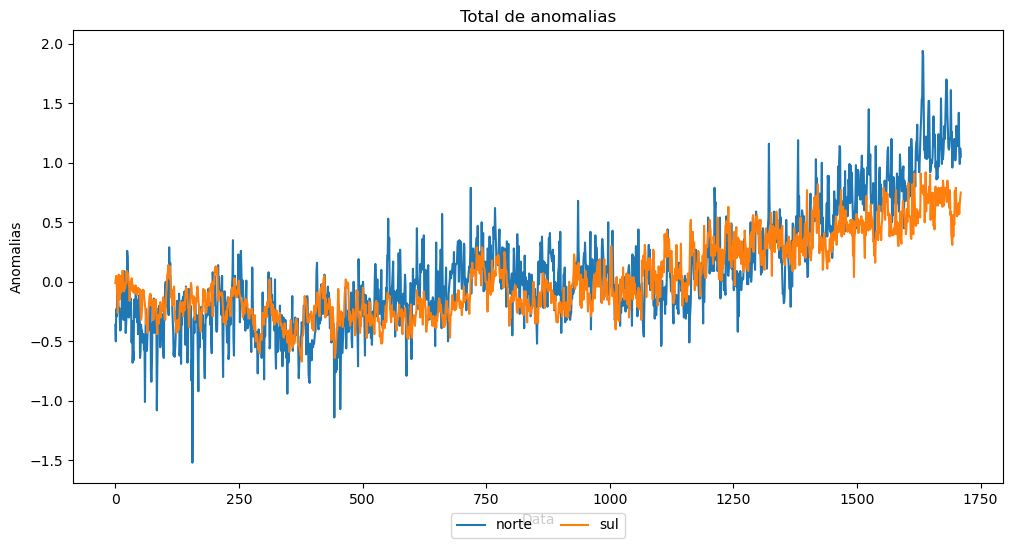

In [13]:
categorias = data.categoria.unique()
idx = pd.date_range(data.date.min(), data.date.max())
cat_num = len(categorias)
print("Categorias {}".format(cat_num))
print(
    "Menor data é {}, maior data é {}".format(
        data.date.min(), data.date.max()
    )
)

qtd_list = []
for key in categorias:
    temp_df = data[["date", "anomalias"]][data.categoria == key]
    temp_df = temp_df.set_index('date').asfreq('M')
    qtd_list.append(temp_df["anomalias"])

plt.figure(figsize=(12, 6), dpi=100, facecolor="w")
for key, cat in enumerate(categorias):
    plt.plot(list(qtd_list[key].values), label=cat)

plt.ylabel("Anomalias")
plt.xlabel("Data")
plt.title("Total de anomalias")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), shadow=False, ncol=4)
plt.show()

In [14]:
length = 120

s3_output_path = "{}/{}/output".format(bucket, prefix)
train_data_path = "s3://{}/{}/train/train.json".format(bucket, prefix)
test_data_path = "s3://{}/{}/test/test.json".format(bucket, prefix)

# Split the data for training and validation/hold out
anomalias_training = []
for i in qtd_list:
    anomalias_training.append((i[:-length].astype(float)))

def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

with open("train.json", "w") as fp:
    for ts in anomalias_training:
        fp.write(series_to_jsonline(ts.astype(str)))
        fp.write("\n")
! aws s3 mv train.json $train_data_path

with open("test.json", "w") as fp:
    for ts in qtd_list:
        fp.write(series_to_jsonline(ts.astype(str)))
        fp.write("\n")
! aws s3 mv test.json $test_data_path

move: ./train.json to s3://sagemaker-leticia-croffi/deepar-example/train/train.json
move: ./test.json to s3://sagemaker-leticia-croffi/deepar-example/test/test.json


## Treinamento

O framework [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/) é utilizado para criar o objeto do [estimator](https://sagemaker.readthedocs.io/en/stable/estimators.html) para rodar o job de treinamento. O parâmetro use_spot indica o uso de [managed spot training](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html). O treinamento irá rodar por no máximo 30 minutos (1800 segundos). 

O framework [Tuning Automático do Modelo](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) ou otimização de Hiperparâmetros é utilizado para identificar os melhores valores para o modelo do DeeAR: [Hiperparâmetros do DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html). O job do Tuning Automático do Modelo irá rodar 10 jobs em paralelo em 10 instâncias (configurado por max_parallel_jobs) para buscar os melhores hiperparâmetros para o dataset. Os jobs tentarão minimizar o erro quadrático médio no dataset de teste usando valores preditos e valores reais.

Você pode aumentar os parâmetros de max_parallel_jobs, max_run e max_wait para encontrar melhores hiperparâmetros, e adicionar hiperparâmetros diferentes para serem tunados.

In [ ]:
%%time
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker import image_uris


container = image_uris.retrieve(region=region, framework="forecasting-deepar")

deepar = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    use_spot_instances=True,  # use spot instances
    max_run=3600,  # max training time in seconds
    max_wait=3600,  # seconds to wait for spot instance
    output_path="s3://{}/{}".format(bucket, s3_output_path),
    sagemaker_session=sess,
)
freq = "M"
context_length = 120

deepar.set_hyperparameters(
    time_freq=freq, context_length=str(context_length), prediction_length=str(length)
)

hyperparameter_ranges = {
    "mini_batch_size": IntegerParameter(100, 400),
    "epochs": IntegerParameter(50, 400),
    "num_cells": IntegerParameter(30, 100),
    "likelihood": CategoricalParameter(["student-t", "gaussian", "deterministic-l1"]),
    "learning_rate": ContinuousParameter(0.0001, 0.1),
}

objective_metric_name = "test:RMSE"

tuner = HyperparameterTuner(
    deepar,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=10,
    strategy="Bayesian",
    objective_type="Minimize",
    max_parallel_jobs=10,
    early_stopping_type="Auto",
)

s3_input_train = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/train/".format(bucket, prefix), content_type="json"
)
s3_input_test = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/test/".format(bucket, prefix), content_type="json"
)

tuner.fit({"train": s3_input_train, "test": s3_input_test}, include_cls_metadata=False)
tuner.wait()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
!
CPU times: user 3.44 s, sys: 452 ms, total: 3.89 s
Wall time: 1h 10min 40s


## Hospedagem (Endpoint)

O framework [HyperParameterTuner](https://sagemaker.readthedocs.io/en/stable/tuner.html) é utilizado para hospedar o melhor modelo com uma instância ml.m4.xlarge instance.

In [ ]:
best_tuning_job_name = tuner.best_training_job()
endpoint = tuner.deploy(
    initial_instance_count=1,
    endpoint_name=best_tuning_job_name,
    instance_type="ml.m4.xlarge",
    serializer=IdentitySerializer(content_type="application/json"),
    deserializer=JSONDeserializer(),
    wait=True,
)


2022-08-22 18:58:05 Starting - Preparing the instances for training
2022-08-22 18:58:05 Downloading - Downloading input data
2022-08-22 18:58:05 Training - Training image download completed. Training in progress.
2022-08-22 18:58:05 Uploading - Uploading generated training model
2022-08-22 18:58:05 Completed - Training job completed
---------!

## Avaliação

Para avaliar o modelo, a classe DeepARPredictor é definida. Essa classe é uma extensão da classe [Predictor](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html). Implementando funções de codificação e decodificação nos ajuda a fazer requests pelo `pandas` ao invés de utilizar strings em JSON.

In [16]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args, serializer=IdentitySerializer(content_type="application/json"), **kwargs
        )

    def set_prediction_parameters(self, freq, length):
        """Set the time frequency and prediction length parameters. This method **must** be
        called before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = length

    def predict(
        self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.05", "0.5", "0.95"]
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the
        (optional) corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: 'utf-8')
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ['0.1', '0.5', '0.9'])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + x.index.freq for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df


predictor = DeepARPredictor(endpoint_name=endpoint.endpoint_name, sagemaker_session=sess)

O objeto `predictor` criado anteriormente pode ser utilizado. As séries temporais serão preditas, e os resultados serão comparados com os dados reais que ficaram no conjunto de teste.

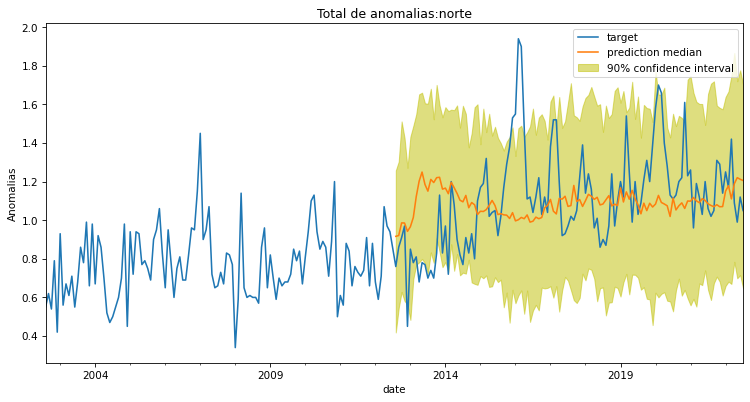

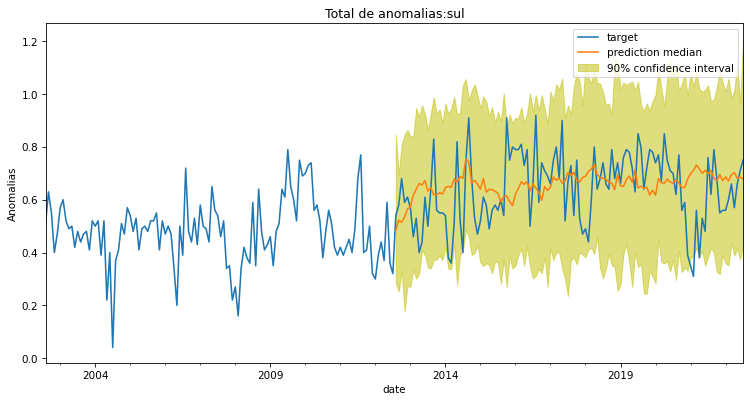

In [19]:
predictor.set_prediction_parameters(freq, length)
list_of_df = predictor.predict(anomalias_training)
actual_data = qtd_list
df_result = pd.DataFrame()
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6), dpi=75, facecolor="w")
    plt.ylabel("Anomalias")
    plt.xlabel("Dia")
    plt.title("Total de anomalias:" + categorias[k])
    actual_data[k][-length - context_length :].plot(label="target")
    p05 = list_of_df[k]["0.05"]
    p95 = list_of_df[k]["0.95"]
    plt.fill_between(p05.index, p05, p95, color="y", alpha=0.5, label="90% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    
    result = pd.concat([p05,list_of_df[k]["0.5"][-length - context_length :], p95,actual_data[k][-length:]], axis=1).rename(columns={'0.05':'lim_inf','0.5':'previsao','0.95':'lim_sup', 'anomalias':'real'})
    result['anomalias'] = categorias[k]
    df_result = pd.concat([df_result, result])
    
    plt.legend()
    plt.show()

In [24]:
df_result

,lim_inf,previsao,lim_sup,real,anomalias
2012-08-31,0.418533,0.916404,1.257403,0.76,norte
2012-09-30,0.544840,0.920555,1.303410,0.86,norte
2012-10-31,0.628562,0.986075,1.511482,0.91,norte
2012-11-30,0.581468,0.985340,1.426155,0.97,norte
2012-12-31,0.562326,0.942058,1.271213,0.45,norte
...,...,...,...,...,...
2022-03-31,0.436797,0.694375,0.981033,0.66,sul
2022-04-30,0.388285,0.703019,1.014076,0.57,sul
2022-05-31,0.415042,0.681297,1.121690,0.66,sul
2022-06-30,0.373919,0.686175,0.964422,0.71,sul


## Previsão dos próximos 10 anos utlizando o modelo tunado

In [20]:
length = 120


# Split the data for training and validation/hold out
anomalias_training = []
for i in qtd_list:
    anomalias_training.append((i.astype(float)))


def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat:
        obj["cat"] = cat
    return obj


def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))


with open("train.json", "w") as fp:
    for ts in anomalias_training:
        fp.write(series_to_jsonline(ts.astype(str)))
        fp.write("\n")

In [26]:
predictor = DeepARPredictor(endpoint_name=endpoint.endpoint_name, sagemaker_session=sess)

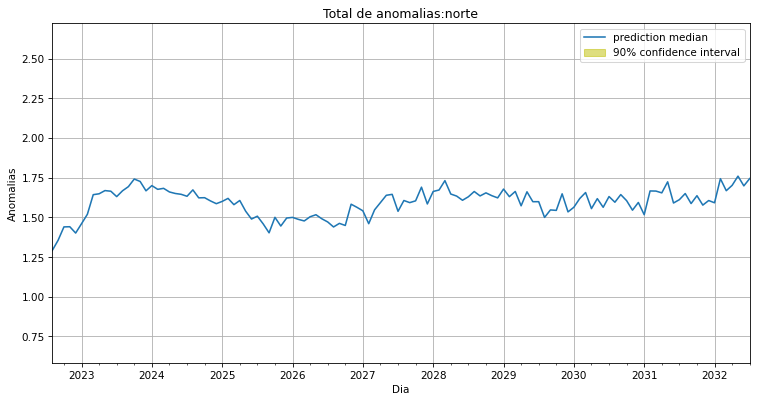

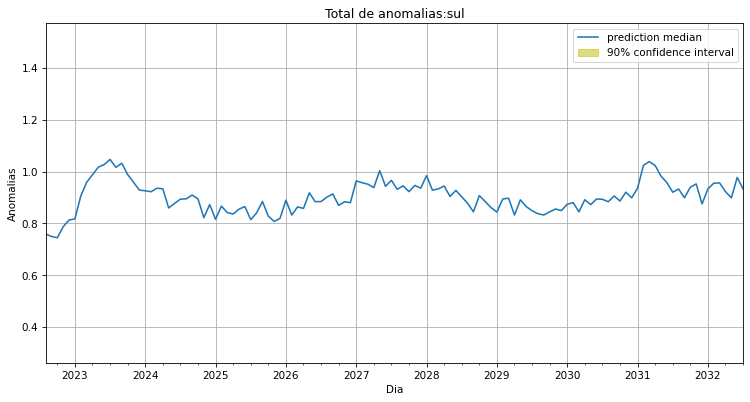

In [22]:
freq = "M"
context_length = 120
predictor.set_prediction_parameters(freq, length)
list_of_df = predictor.predict(anomalias_training)
df_result = pd.DataFrame()
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6), dpi=75, facecolor="w")
    plt.ylabel("Anomalias")
    plt.xlabel("Dia")
    plt.title("Total de anomalias:" + categorias[k])
    p05 = list_of_df[k]["0.05"]
    p95 = list_of_df[k]["0.95"]
    plt.fill_between(p05.index, p05, p95, color="y", alpha=0.5, label="90% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    
    result = pd.concat([p05,list_of_df[k]["0.5"][-length - context_length :], p95], axis=1).rename(columns={'0.05':'lim_inf','0.5':'previsao','0.95':'lim_sup'})
    result['categorias'] = categorias[k] 
    df_result = pd.concat([df_result, result])
    
    plt.grid()
    plt.legend()
    plt.show()

### Limpeza

Ao final do exercício, delete o endpoint para não acumular gastos na sua conta.

In [24]:
predictor.delete_model()
predictor.delete_endpoint()